# 把MODIS land cover hdf数据转换为nc数据

In [30]:
from pyhdf.SD import SD, SDC
import pprint
import pandas as pd
import numpy as np
import xarray as xr
path = '/mnt/d/cym/MODIS LAND_USE-0.05-QuanQiu/'
filename = 'MCD12C1.A2001001.006.hdf'
HDF_FILR_URL = path + filename
file = SD(HDF_FILR_URL)
print(file.info())
datasets_dic = file.datasets()
for idx,sds in enumerate(datasets_dic.keys()):
    print(idx,sds)

(9, 6)
0 Majority_Land_Cover_Type_1
1 Majority_Land_Cover_Type_1_Assessment
2 Land_Cover_Type_1_Percent
3 Majority_Land_Cover_Type_2
4 Majority_Land_Cover_Type_2_Assessment
5 Land_Cover_Type_2_Percent
6 Majority_Land_Cover_Type_3
7 Majority_Land_Cover_Type_3_Assessment
8 Land_Cover_Type_3_Percent


## 把每年land cover hdf数据转为每年LC nc数据

In [36]:
import glob
path = '/mnt/d/cym/MODIS LAND_USE-0.05-QuanQiu/'
filename = '*.hdf'
HDF_FILE_URL = path + filename
hdf_files = glob.glob(HDF_FILE_URL)
def create_nc(Majority_Land_Cover_Type_1,Majority_Land_Cover_Type_1_Assessment,Land_Cover_Type_1_Percent,yr):
    # 新建字典
    nc_dict = {
        # nc文件的维度信息
        "dims": {"lat": 3600, "lon": 7200,"num":17},
        # nc文件的维度信息的坐标信息（lat,lon,time等）
        "coords": {
            "lat": {
                "dims": ("lat",),
                "attrs": {
                    "standard_name": "latitude",
                    "long_name": "Latitude",
                    "units": "degrees_north",
                    "axis": "Y",
                },
                "data":np.linspace(90,-90,3600,endpoint=True,dtype=np.float64), #维度从小到大(4-53.5)
            },
            "lon": {
                "dims": ("lon",),
                "attrs": {
                    "standard_name": "longitude",
                    "long_name": "Longitude",
                    "units": "degrees_east",
                    "axis": "X",
                },
                "data":np.linspace(-180,180,7200,endpoint=True,dtype=np.float64), # 经度从小到大(73.5-135)
            },
            "num":{
                "dims": ("num",),
                "attrs": {
                    "standard_name": "num",
                    "long_name": "num",
                    "units": "degrees_east",
                },
                "data":np.arange(17), # 经度从小到大(73.5-135)
            }

            # "time": {
            #     "dims": ("time",),
            #     "attrs": {"standard_name": "time", "long_name": "Time"},
            #     "data":np.arange(np.datetime64('2013-01-01T00:00:00','s'),np.datetime64('2014-12-31T19:00:00','s'),np.timedelta64(6,'h'))
            # },
        },
        # nc文件中的变量
        "data_vars": {
            "LC_Type": {
                "dims": ("lat", "lon"),
                "attrs": {
                    "long_name": "Majority_Land_Cover_Type_1",
                    "units": "mw/m^2/nm/sr",
                    "precision": 2,
                    "GRIB_id": 11,
                    "GRIB_name": "ADSIF",
                    "var_desc": "Deta SIF",
                    "dataset": "OCO-2 Continuous",
                    "level_desc": "Surface",
                    "statistic": "Satellite-Based",
                    "parent_stat": "Other",
                    "actual_range": [-0.1, 0.1],
                },
                "data":Majority_Land_Cover_Type_1,
            },
            "LC_Assessment": {
                "dims": ("lat", "lon"),
                "attrs": {
                    "long_name": "Majority_Land_Cover_Type_1",
                    "units": "mw/m^2/nm/sr",
                    "precision": 2,
                    "GRIB_id": 11,
                    "GRIB_name": "ADSIF",
                    "var_desc": "Deta SIF",
                    "dataset": "OCO-2 Continuous",
                    "level_desc": "Surface",
                    "statistic": "Satellite-Based",
                    "parent_stat": "Other",
                    "actual_range": [-0.1, 0.1],
                },
                "data":Majority_Land_Cover_Type_1_Assessment,
            },
            "LC_Percent": {
                "dims": ("lat", "lon","num"),
                "attrs": {
                    "long_name": "Majority_Land_Cover_Type_1",
                    "units": " ",
                    "precision": 2,
                    "GRIB_id": 11,
                    "GRIB_name": "ADSIF",
                    "var_desc": "Deta SIF",
                    "dataset": "OCO-2 Continuous",
                    "level_desc": "Surface",
                    "statistic": "Satellite-Based",
                    "parent_stat": "Other",
                    "actual_range": [-0.1, 0.1],
                },
                "data":Land_Cover_Type_1_Percent,
            }

        },
        # nc文件的全局属性信息
        "attrs": {
            "Conventions": "COARDS",
            "title": "Majority_Land_Cover_Type_1",
            "description": "Data is from MODIS",
            "platform": "Model",
            "references": " ",
        },
    }

    # 使用`from_dict`，将字典转化为xr.Dataset对象
    ds = xr.Dataset.from_dict(nc_dict)
    # 将xr.Dataset对象保存为nc文件
    ds.to_netcdf("/mnt/d/cym/RF_data/"+str(yr)+".nc")
    return

i = 2001
for hdf_file in hdf_files:
    file = SD(hdf_file)
    Majority_Land_Cover_Type_1 = file.select('Majority_Land_Cover_Type_1').get() 
    Majority_Land_Cover_Type_1_Assessment = file.select('Majority_Land_Cover_Type_1_Assessment').get() 
    Land_Cover_Type_1_Percent = file.select('Land_Cover_Type_1_Percent').get() 
    create_nc(Majority_Land_Cover_Type_1,Majority_Land_Cover_Type_1_Assessment,Land_Cover_Type_1_Percent,i)
    i += 1

## 把每年nc数据合并在一起，并把LC赋予给年内每月的值

### LC数据赋给每月的原因是WRR 预测干旱的研究中需要每月的土地利用数据

In [37]:
import xarray as xr
import numpy as np
data = np.full((20,3600,7200),np.nan)
for yr in range(2001,2021):
    filename = "/mnt/d/cym/RF_data/"+str(yr)+".nc"
    ds = xr.open_dataset(filename).LC_Type.values
    data[yr-2001,::] = ds

In [38]:
data = np.repeat(data,12,axis=0)
da = xr.DataArray(
    data=data,
    dims=["time","lat", "lon"],
    coords={
        'time':np.arange('2001', '2021', dtype='datetime64[M]'),
        'lon': np.linspace(-180,180,7200,endpoint=True),
        'lat': np.linspace(90,-90,3600,endpoint=True),
    },
)

da.to_netcdf("/mnt/d/cym/RF_data/LC.nc")


In [39]:
import xarray as xr
import numpy as np
ds = xr.open_dataarray("/mnt/d/cym/RF_data/LC.nc")


In [44]:
da = ds.loc[:,60:45,70:110]

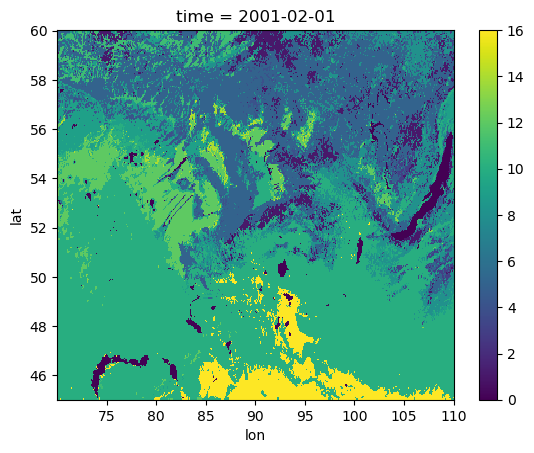

In [48]:
da[0,::].plot()

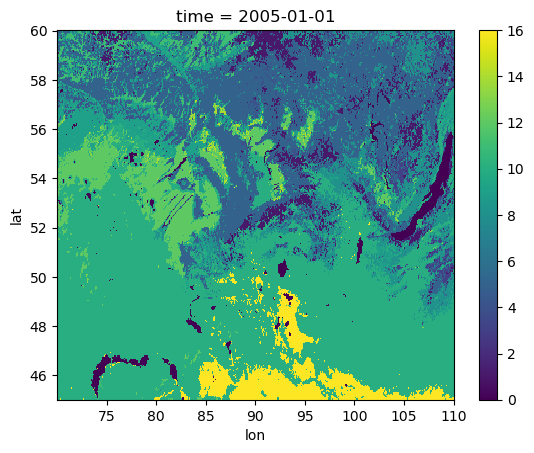

In [54]:
da[48,::].plot()

In [6]:
ds.values[ds.values==0] = np.nan

In [114]:
ds = ds.astype(float)
# ds.values[ds.values==0] = np.nan
# ds.values[ds.values!=10] = np.nan
ds.values[ds.values<90] = np.nan